# 经典机器学习的归一化算法 

## 经典机器学习归一化方法回顾 

### 0-1标准化方法 

0-1标准化是最简单也是最容易想到的方法，同时也是经典机器学习领域最常用的标准化方法。该方法通过在输入特征中逐列遍历其中里的每一个数据，将MaxMin的记录下来，并通过Max-Min作为基数(即Min=0，Max=1) 进行数据的归一化处理，基本公式为:

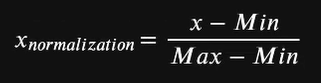

In [6]:
t = torch.tensor([[ 0.,  11.],
        [ 2.,  3.],
        [ 4.,  5.],
        [ 6.,  7.],
        [ 8.,  9.],
        [10., 1.]])
t

tensor([[ 0., 11.],
        [ 2.,  3.],
        [ 4.,  5.],
        [ 6.,  7.],
        [ 8.,  9.],
        [10.,  1.]])

In [7]:
t_max = t.max(0)[0] # 提取每列最大值
t_max

tensor([10., 11.])

In [8]:
t_min = t.min(0)[0] # 提取每列最小值
t_min

tensor([0., 1.])

In [9]:
(t - t_min) / (t_max - t_min) # 计算0-1标准化后的结果

tensor([[0.0000, 1.0000],
        [0.2000, 0.2000],
        [0.4000, 0.4000],
        [0.6000, 0.6000],
        [0.8000, 0.8000],
        [1.0000, 0.0000]])

### Z-Score标准化 

和0-1标准化不同，Z-score标准化利用原始数据的均值 (mean)和标准差 (standard deviation)进行数据的标准化。同样是逐列进行操作，每一条数据都减去当前列的均值再除以当前列的标准差。很明显，通过这种方法处理之后的数据是典型的Zero-Centered Data，并且如果原数据服从正态分布，通过ZScore处理之后将服从标准正态分布。ZScore标准化计算公式如下:

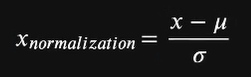

其中u代表均值，o代表标准差。当然，我们也可通过如下方式对张量进行Z-Score标准化处理

In [10]:
t

tensor([[ 0., 11.],
        [ 2.,  3.],
        [ 4.,  5.],
        [ 6.,  7.],
        [ 8.,  9.],
        [10.,  1.]])

In [13]:
t.mean(0)

tensor([5., 6.])

In [14]:
t.std(0)

tensor([3.7417, 3.7417])

In [15]:
(t - t.mean(0)) / t.std(0)

tensor([[-1.3363,  1.3363],
        [-0.8018, -0.8018],
        [-0.2673, -0.2673],
        [ 0.2673,  0.2673],
        [ 0.8018,  0.8018],
        [ 1.3363, -1.3363]])

能够看出，上述处理之后得到的数据就是Zero-Centered Data。为了后续实验需要，我们可以将Z-Score标准化过程封装为一个函数，方便调用:

In [66]:
def Z_ScoreNormalization(data):
    stdDf = data.std(0)
    meanDf = data.mean(0)
    normSet = (data - meanDf) / stdDf
    return normSet

<b>一种更知严谨的做法，是在分母项、也就是标准差上加上一个非常小的常数从，从而使得分母恒大于0。

<li> 在训练集上训练，测试集上测试

在建模之前，首先需要明确两个问题，其一是标签是否需要标准化(如果是回归类问题的话)，其是测试集的特征是否需要标准化?

首先，标签是否标准化对建模没有影响，因此一般我们不会对标签进行标准化;其次，在实际模型训练过程中，由于数据集要划分成训练集和测试集，因此一般来说我们会在训练集的特征中逐行计算其均值和标准差，然后进行模型训练，当输入测试集进行测试时，我们会将在训练集上计算得出的每一列的均值和标准差带入测试集并对测试集特征进行标准化，然后再带入进行模型测试。值得注意的是，此时进行标准化时涉及到的每一列的均值和方差也相当于是模型参数，必须从训练集上得出，不能借助测试集的数据

###  Z-Score数据归一化的局限

不过，毕竟Z-Score初始化并不是为深度学习算法量身设计的数据归一化方法，在实际神经网络建模过程中，Z-Score的使用还是存在很多局限，具体来说主要有以下两点。

#### Zero-Centered特性消失

尽管Z-Score归一化能够一定程度保证梯度平稳，进而提升模型收敛速度甚至是提升模型效果，但是，和Xavier初始化方法一样，由于是对于“初始值”的修改，因此也会存在随着迭代次数增加就逐渐破坏了Zero-Centered Data这一条件的问题，当然，该问题也可视作经典机器学习归一化方法应用于深度神经网络时的局限。

并且，随着参数和输入数据都回到不可控状态，各层的梯度又将回到不可控的状态而所谓的控制梯度平稳性也将无从谈起。例如，我们尝试创建相对梯度容易不平稳的tanh激活函数模型，查看选代5轮和40轮时各层梯度变化情况。

#### Zero-Centered Data的作用局限 

除了输入数据在迭代过程中会逐渐丧失Zero-Centered特性外，Z-Score标准化在应用到深度学习模型中，还会面临一个更加严峻的问题一那就是Zero-Centered Data本身作用范围也是有限的。我们哪怕能够维持输入数据的Zero-Centered特性，也很难保证只凭借这一点就能确保梯度平稳。

在Lesson 13中，我们知道深度学习中保证各层梯度平稳，是确保模型能够顺利有效进行学习的关键而所谓的梯度平稳，我们可以用Glorot条件来进行描述，即正向传播过程中数据流经各层时输入和输出数据方差相同，反向传播时数据流经各层前后该层梯度的方差相同

尽管此前我们一直强调零均值数据的良好特性，但归根结底还是因为零均值数据在各层梯度计算过程中，可以使得激活函数导函数输出结果尽可能大 (ReLU激活函数时能够避免Dead ReLU Problem)，从而确保梯度计算的有效性。此处我们不妨回顾此前我们得出的三层神经网络中各层梯度的计算公式.

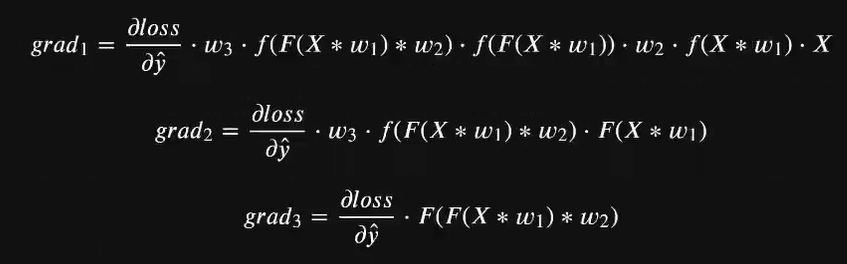

由于各层的梯度实际上受到激活函数、各层输入数据和参数三者共同影响，因此哪怕我们将所有的输入数据都调整为零均值的，各层梯度的计算结果还是有可能因为受到其他因素影响导致不平稳。因此，一味追求输入数据的Zero-Centered或许并不是最好的选择

#  Batch Normalization基础理论

根据《Batch Normalization: Accelerating Deep Network Training by Reducing lnternal CovariateShif》一文中的观点，作者认为在深度神经网络模型训练过程中，容易出现一种名为内部协方差偏移(lnternal Covariate Shift、ICS)的问题，该问题会导致模型性能下降，而为了解决该问题，作者提出了BN方法，并在各种实验中验证了BN对模型效果提升的有效性。

然而，到底什么是ICS，作者在原文中只给出了简单的描述而未给出严格定义，并且对于BN可以提升模型性能方面，作者表示根本原因是因为BN能够消除ICS。有趣的是，尽管这套理论没有在原文中给出更加严谨的说明和论证，但由于BN方法本身在应用实践中效果很好，因此大多数情况下人们并未对原文中论述不严谨的理论推导部分进行深究。直到2018年，来自MIT的研究团队发表论文，《How Does BatchNormalization Help Optimization?》，研究人员表示，通过一些列严谨的实验可以证明，BN方法对模型优化的有效性和原论文中所描述的消除ICS没有任何关系，甚至在某些场景下BN还会加剧模型的ICS，而到底是什么让BN如此有效，MIT的研究团队最终也没有给出严谨的理论证明。如此一来BN方法就成了基础理论“不成立”但实际上很好用的一项优化方法，而对于BN的有效性的理论研究，也成为了诸多科研团队的命题。

## 归一化方法与数据分布的相互独立性

首先，我们需要知道，任何归一化的本质都是对数据进行平移和放缩，所谓平移，就是指数据集每列统一加上或减去某一个数，在Z-Score中就是每一列减去该列的均值，而所谓的放缩，就是指数据集中每一列数据统一除以或乘以某一个数，在Z-Score中就是每一列除以当前列的标准差。而数据的平移和放缩，是不会影响数据特征的分布情况的。

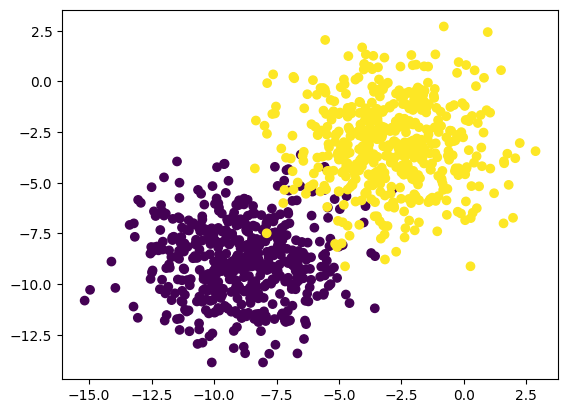

In [58]:
torch.manual_seed(420)

features,labels = tensorGenCla(num_class=2,deg_dispersion=[6,2])

plt.scatter(features[:,0],features[:,1],c = labels)

In [61]:
features

tensor([[-9.0141, -7.9911],
        [-7.6593, -9.7657],
        [-8.9395, -8.2347],
        ...,
        [-2.0377, -2.9139],
        [-4.5465, -5.2140],
        [-7.6681, -1.6065]])

In [60]:
f = Z_ScoreNormalization(features)
f

tensor([[-3.5051, -3.2892],
        [-3.1286, -3.7976],
        [-3.4844, -3.3590],
        ...,
        [-1.5663, -1.8347],
        [-2.2635, -2.4936],
        [-3.1311, -1.4602]])

<Axes: >

Text(0.5, 1.0, 'features distribution')

<Axes: >

Text(0.5, 1.0, 'f distribution')

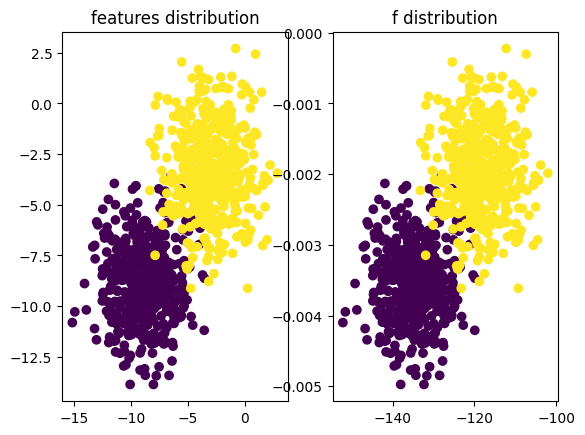

In [22]:
plt.subplot(121)
plt.scatter(features[:,0],features[:,1],c = labels)
plt.title('features distribution')
plt.subplot(122)
plt.scatter(f[:,0]*10-100,f[:,1]*0.001,c = labels)
plt.title('f distribution')

而比较重要的一点是，数据的分布其实就代表着数据背后的规律，我们使用模型去捕捉数据规律，其实就是对数据分布情况进行学习。因此，数据归一化不修改数据分布，是我们使用归一化方法的基本前提，否则，一旦数据归一化方法会修改数据分布，则相当于是人为破坏了数据原始规律，这将会对后续的模型学习造成巨大的影响。

算法也会不加区分的进行学习在任何情况下，机器学习建模都应避免人为修改数据规律，因为一旦加入人为创造的规律

##  归一化与仿射变换

需要补充的第二点基础理论就是，归一化的本质仍然是对数据进行仿射变换。根据此前介绍，数据的仿射变换用矩阵形式来进行表示就是:

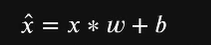

其中x是原数据，w是参数矩阵，b是截距，x是经过变换之后的数据。此处以Z-Score为例，探讨归一化操作转化为仿射变换的方法。

In [63]:
x = torch.arange(1,5).reshape(2,2).float()
x

tensor([[1., 2.],
        [3., 4.]])

In [64]:
Z_ScoreNormalization(x)

tensor([[-0.2929,  0.4142],
        [ 1.1213,  1.8284]])

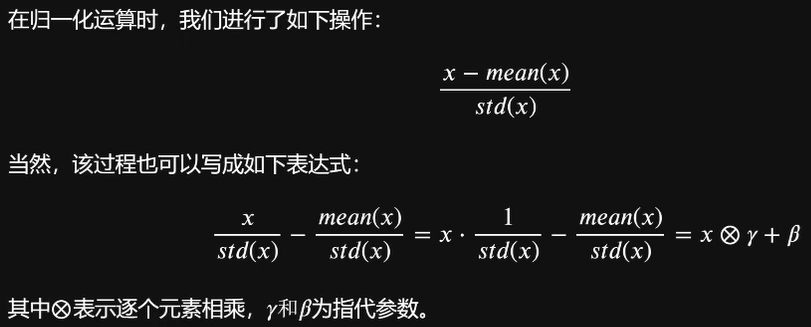

In [46]:
x / x.std(0)

tensor([[0.7071, 1.4142],
        [2.1213, 2.8284]])

In [47]:
r = torch.tensor(1.)/x.std(0) # 每列的标准差

In [48]:
rm = torch.diag(r) # 构建以每列标准差分之一为对负线元素的对角知阵
rm

tensor([[0.7071, 0.0000],
        [0.0000, 0.7071]])

In [49]:
torch.mm(x,rm)

tensor([[0.7071, 1.4142],
        [2.1213, 2.8284]])

In [50]:
b = -(x.mean(0)/x.std(0))
b

tensor([-1.4142, -2.1213])

In [51]:
torch.mm(x,rm)+b

tensor([[-0.7071, -0.7071],
        [ 0.7071,  0.7071]])

In [67]:
Z_ScoreNormalization(x)

tensor([[-0.7071, -0.7071],
        [ 0.7071,  0.7071]])

<b>至此，我们可以发现，在归一化的过程中，放缩的部分可以通过矩阵乘法来完成</b>，假设原数据为一个m*n的数据集，则令其左乘一个对角线元素为原数据集每一列放缩参数的矩阵即可完成放缩，而平移部分则更加简单，令数据集加上由每一列平移幅度所构成的向量即可完成平移。

而如果归一化是一种放射变换，并且归一化的计算过程可以用矩阵运算来完成，那么就有两方面的直接影响，其一，PyTorch中对数据的仿射变换是用线性层完成的，既然归一化是一种特殊的仿射变换，归一化的操作也可以由一个特殊的线性层来完成，并且和所有的线性层一样，归一化层也可以放置在任何隐藏层前后;其二，在具体实现层面上，在仿射变换中我们是可以设置参数、并且通过构建损失函数再利用梯度下降进行求解的，那么对于归一化这种特殊的仿射变换，平移和放缩的尺度是否可以简单设计成一个参数，然后带入模型进行训练求解呢?

当然是可以的，并且这么做是非常有必要的! 如前文所述，将数据转化为Zero-Centered Data并非最好的选择，如果可以通过梯度下降求解出最佳放缩和平移的尺度，大概率会比简单使用Z-Score将其放缩为均值为0、方差为1的数据分布效果更好(至少不会差)。另外，我们将归一化操作看成一个特殊的线性层，也将极大拓展归一化操作可以出现的位置。在经典机器学习领域，对数据的归一化只停留在输入数据时对数据进行统一处理，但正如前文所述，如果只对初始输入数据进行归一化，那么在迭代过程中，数据会逐渐失去初始化之后所带来的良好特性，此时如果我们可以像添加线性层一样，在任意隐藏层前后添加归一化层，则可以在迭代的每个环节对数据进行归一化，如此一来就能避免迭代过程中数据逐渐偏移所导致的梯度不平稳问题。

而实际上，BN就是这么做的。在BN中，以每次输入的小批数据为训练数据，我们将平移和放缩的尺度视作参数，通过带入模型进行训练，最终得出最佳平移和放缩尺度，并且这种BN归一化层会可以出现在步进行归一化操作。具体原理如下节所示任意隐藏层的前后，为数据传输的每

当然，这里需要补充一点。将平移和放缩的尺度视为参数，则代表我们不是朝着零均值的方向去进行归一化处理，实际上在参数化尺度的时候，参数迭代的方向自然就变成了尽量保持各层梯度平稳，这也是参数化归一化尺度的有效性的最佳证明。相关数学原理可参考上述两篇论文，课上不对此进行拓展

实际上，均值为0、方差为1的归一化却是也不一定是最优选择，根据各层梯度计算公式不难看出，最佳的数据归一化方法并不是绝对的0均值1方差，而是能够使得最终各变量相乘之后梯度保持均衡

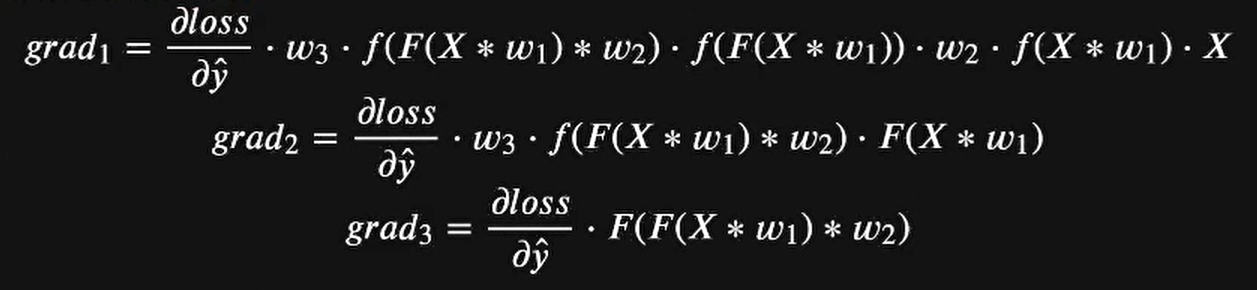

## Batch Normalization基本流程

有了基本认知之后，接下来我们来讨论Batch Normalization的基本实现流程。作为针对数据归一化方法，Batch Normalization的理论实现流程看似更加复杂，但实际上，和所有的归一化方法一样，BN做的也就是对输入数据进行平移和放缩。只不过BN的平移和放缩分为两个阶段，第一个阶段是进行Z-Score处
理，也就是将输入数据的均值平移至0点，并将输入数据的方差放缩至1;第二阶段则是在此基础上在对数据的均值进行参数平移(加上一个通过训练、也就是梯度下降算法算得的参数)，并对其方差进行参数(另一个通过模型训练、也就是梯度下降算得的参数)放缩。具体数学过程如下:

<li> Stage1: Z-Score放缩

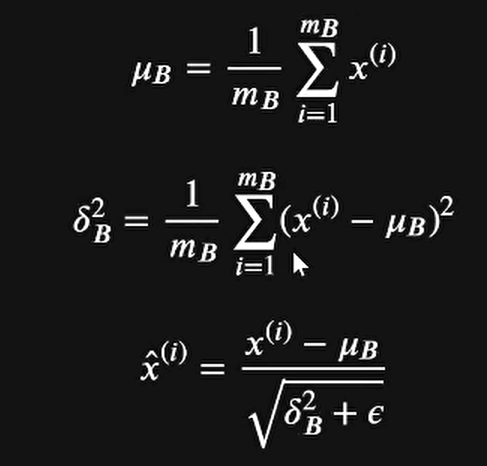

其中uB代表输入的小批数据均值，&B代表输入的小批数据方差，代表Z-Score归一化后的数据结果，和此前一样，Z-Score计算过程为减去每一列的元素减去该列的均值除以该列的修正后的标准差(方差加上一个极小的数使得其不为零》。第一阶段的参数都是可以计算或者人工设置的，其中均值和方差都是简单计算即可得出，而修正项e则是可以手动设置的。

<li> Stage2: 带参数的平移和放缩

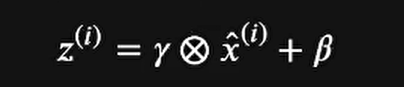

和第一阶段参数可以简单计算得出不同，二阶段的参数，也就是y和6都是模型参数，在实际模型训练过程中是需要作为模型整体参数的一部分，带入损失函数、进而通过梯度下降计算得出的。而二阶段的实际处理数据过程，则是首先对一阶段放缩之后每一列的乘以一个固定的y在加上一个固定的8。需要强调的是，上述公式是针对列进行处理，即每一列都乘以一个y再加上一个B，并不是所有数据都乘以一个y再加上一个B，也不是每一个数据都乘以一个y再加上一个B。

<li> BN的两个阶段的关系

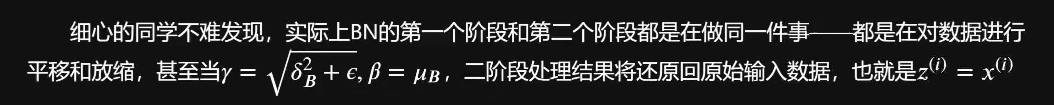

既然两个阶段做的相同的事情，为何不能直接合并为一个阶段。从理论上来说，我们可以将上述过程合并为:

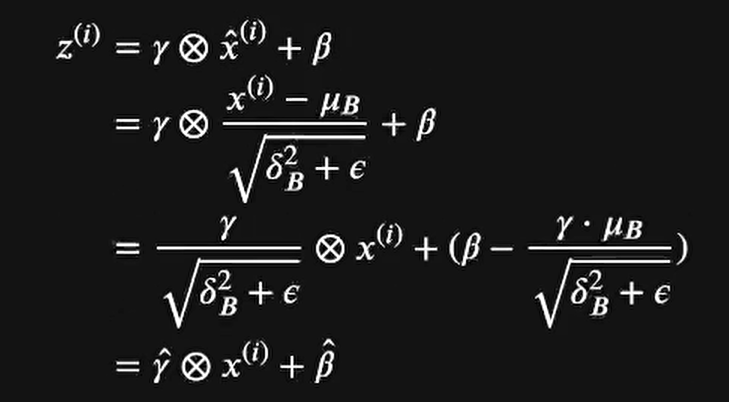

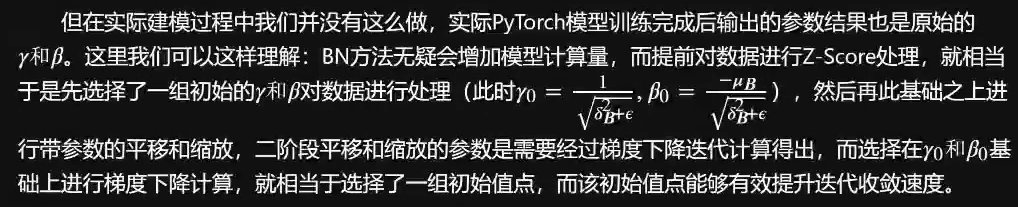

<li> 数据归一化和仿射变换

根据前文论述我们知道,数据归一化本质也是对数据进行一种特殊的仿射变换,并且在PyTorch中,
仿射变换是能通过矩阵运算来实现。既然如此,我们在PyTorch中进行BN归一化的操作其实就可以视作添加了一层特殊的线性层来进行计算,其中线性层的参数就是y和β,实际的计算过程如下:

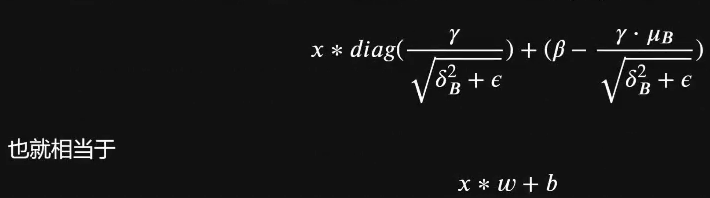

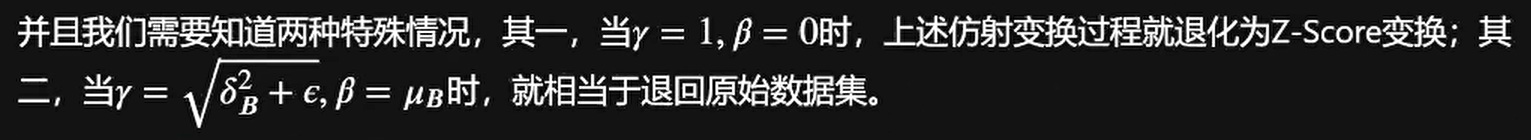